#One Notebook to Rule Them All

Imports

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h516909a_0.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py37ha21ca33_2.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.7/dist-packages/ lib/python3.7/site-packages/talib --strip-components=3
import talib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3741    0  3741    0     0   3805      0 --:--:-- --:--:-- --:--:--  3801
100  503k  100  503k    0     0   183k      0  0:00:02  0:00:02 --:--:--  333k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3749    0  3749    0     0   4066      0 --:--:-- --:--:-- --:--:--  4066
100  406k  100  406k    0     0   165k      0  0:00:02  0:00:02 --:--:--  353k


In [ ]:
from pathlib import Path
import requests
from io import BytesIO
from zipfile import ZipFile, BadZipFile

import numpy as np
import pandas as pd
import pandas_datareader.data as web
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer
import joblib

from time import time
from io import StringIO
import sys, os
from tqdm import tqdm

from itertools import product
from pathlib import Path

import statsmodels.api as sm

import lightgbm as lgb

from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr

pd.set_option('display.expand_frame_repr', False)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')

idx = pd.IndexSlice

Read price data from Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
prices = (pd.read_csv('drive/MyDrive/Colab Notebooks/ML4T/Machine-Learning-for-Algorithmic-Trading-Second-Edition-master/data/btc_v_d.csv', index_col=0,
                     parse_dates=True).loc['1789':'2022'].rename(columns=str.lower))
prices = prices.drop('volume', axis=1)
prices

,open,high,low,close
Date,,,,
2010-07-17,0.04951,0.04951,0.04951,0.04951
2010-07-18,0.04951,0.08585,0.04951,0.08584
2010-07-19,0.08584,0.09307,0.07723,0.08080
2010-07-20,0.08080,0.08181,0.07426,0.07474
2010-07-21,0.07474,0.07921,0.06634,0.07921
...,...,...,...,...
2022-01-19,42493.69000,42577.92000,41152.34000,41989.48000
2022-01-20,41989.47000,43518.05000,40864.09000,41175.47000
2022-01-21,41172.59000,41185.17000,35560.11000,36138.81000


Calculate lagging returns

In [ ]:
intervals = [1, 5, 10, 21, 63]

In [ ]:
returns = []
for t in intervals:
    returns.append(prices['close'].pct_change(t).to_frame(f'ret_{t}'))
returns = pd.concat(returns, axis=1)

returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4209 entries, 2010-07-17 to 2022-01-23
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ret_1   4208 non-null   float64
 1   ret_5   4204 non-null   float64
 2   ret_10  4199 non-null   float64
 3   ret_21  4188 non-null   float64
 4   ret_63  4146 non-null   float64
dtypes: float64(5)
memory usage: 197.3 KB


In [ ]:
max_ret = returns.groupby(level='Date').max()
percentiles = [0.001, .005, .01, .025, .05, .1]
percentiles += [1-p for p in percentiles]
max_ret.describe(percentiles=sorted(percentiles)[6:])

,ret_1,ret_5,ret_10,ret_21,ret_63
count,4208.000000,4204.000000,4199.000000,4188.000000,4146.000000
mean,0.005315,0.025004,0.053027,0.123004,0.545125
std,0.078608,0.159248,0.246309,0.438812,1.977606
min,-0.572057,-0.698386,-0.807906,-0.881174,-0.847093
50%,0.001667,0.009935,0.017196,0.034912,0.156493
90%,0.051662,0.147093,0.244483,0.446478,1.334380
95%,0.080188,0.222090,0.372660,0.701673,2.645107
97.5%,0.117871,0.309844,0.643534,1.230639,3.811812
99%,0.175306,0.529478,0.975330,2.327253,8.002798
99.5%,0.248798,0.740691,1.182437,2.863186,12.774345


Remove outliers

In [ ]:
quantiles = max_ret.quantile(.95)
to_drop = []
for ret, q in quantiles.items():
    to_drop.extend(max_ret[max_ret[ret] > q].index.tolist()) 

to_drop = pd.Series(to_drop).value_counts()
to_drop = to_drop[to_drop > 1].index.tolist()
len(to_drop)

268

In [ ]:
prices = prices.drop(to_drop)
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3941 entries, 2010-07-17 to 2022-01-23
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    3941 non-null   float64
 1   high    3941 non-null   float64
 2   low     3941 non-null   float64
 3   close   3941 non-null   float64
dtypes: float64(4)
memory usage: 153.9 KB


Calculate returns again

In [ ]:
returns = []
by_sym = prices.close
for t in intervals:
    ret = by_sym.pct_change(t)
    rel_perc = pd.qcut(ret, q=20, labels=False, duplicates='drop')
    returns.extend([ret.to_frame(f'ret_{t}'), rel_perc.to_frame(f'ret_rel_perc_{t}')])
returns = pd.concat(returns, axis=1)

returns

,ret_1,ret_rel_perc_1,ret_5,ret_rel_perc_5,ret_10,ret_rel_perc_10,ret_21,ret_rel_perc_21,ret_63,ret_rel_perc_63
Date,,,,,,,,,,
2010-07-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-18,0.733791,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-19,-0.058714,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-20,-0.075000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-21,0.059807,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-01-19,-0.011909,5.0,-0.029449,5.0,-0.005115,8.0,-0.111974,3.0,-0.300083,2.0
2022-01-20,-0.019386,3.0,-0.048165,3.0,-0.010324,7.0,-0.125478,3.0,-0.272706,2.0
2022-01-21,-0.122322,0.0,-0.163594,0.0,-0.154003,1.0,-0.219609,1.0,-0.375914,1.0


Calculate some technical indicators

In [ ]:
ppo = talib.PPO(prices.close).to_frame('PPO')
natr = talib.NATR(prices.high, prices.low, prices.close).to_frame('NATR')
rsi = talib.RSI(prices.close).to_frame('RSI')
u, m, l = talib.BBANDS(prices.close)
bbands = pd.DataFrame({'u': u, 'm': m, 'l': l})

data = pd.concat([prices, returns, ppo, natr, rsi, bbands], axis=1)
data['bbl'] = data.close.div(data.l)
data['bbu'] = data.u.div(data.close)
data = data.drop(['u', 'm', 'l'], axis=1)
print(data.bbu.corr(data.bbl, method='spearman'))
data

0.05237744467866511


,open,high,low,close,ret_1,ret_rel_perc_1,ret_5,ret_rel_perc_5,ret_10,ret_rel_perc_10,ret_21,ret_rel_perc_21,ret_63,ret_rel_perc_63,PPO,NATR,RSI,bbl,bbu
Date,,,,,,,,,,,,,,,,,,,
2010-07-17,0.04951,0.04951,0.04951,0.04951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-18,0.04951,0.08585,0.04951,0.08584,0.733791,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-19,0.08584,0.09307,0.07723,0.08080,-0.058714,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-20,0.08080,0.08181,0.07426,0.07474,-0.075000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-21,0.07474,0.07921,0.06634,0.07921,0.059807,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.633084,1.256617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-19,42493.69000,42577.92000,41152.34000,41989.48000,-0.011909,5.0,-0.029449,5.0,-0.005115,8.0,-0.111974,3.0,-0.300083,2.0,-5.127588,4.570312,36.519255,1.010945,1.040338
2022-01-20,41989.47000,43518.05000,40864.09000,41175.47000,-0.019386,3.0,-0.048165,3.0,-0.010324,7.0,-0.125478,3.0,-0.272706,2.0,-4.490577,4.788151,33.810322,1.007631,1.056966
2022-01-21,41172.59000,41185.17000,35560.11000,36138.81000,-0.122322,0.0,-0.163594,0.0,-0.154003,1.0,-0.219609,1.0,-0.375914,1.0,-4.398768,6.177595,22.626480,1.002179,1.258955


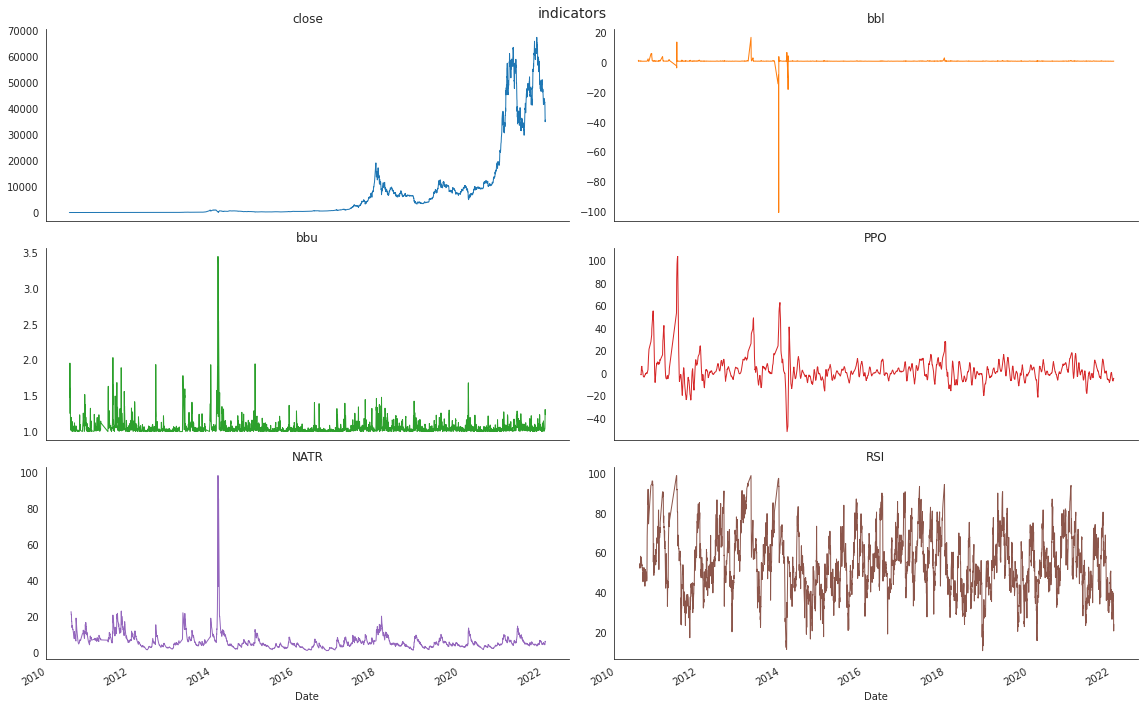

In [ ]:
indicators = ['close', 'bbl', 'bbu', 'PPO', 'NATR', 'RSI']
(data[indicators]
 .plot(lw=1, subplots=True, figsize=(16, 10), title=indicators, layout=(3, 2), legend=False))
plt.suptitle('indicators', fontsize=14)
sns.despine()
plt.tight_layout()
plt.subplots_adjust(top=.95)

In [ ]:
dates = data.index.get_level_values('Date')
data['weekday'] = dates.weekday
data['month'] = dates.month
data['year'] = dates.year

outcomes = []
for t in intervals:
    k = f'fwd_ret_{t:02}'
    outcomes.append(k)
    data[k] = data[f'ret_{t}'].shift(-t)
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3941 entries, 2010-07-17 to 2022-01-23
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   open             3941 non-null   float64
 1   high             3941 non-null   float64
 2   low              3941 non-null   float64
 3   close            3941 non-null   float64
 4   ret_1            3940 non-null   float64
 5   ret_rel_perc_1   3940 non-null   float64
 6   ret_5            3936 non-null   float64
 7   ret_rel_perc_5   3936 non-null   float64
 8   ret_10           3931 non-null   float64
 9   ret_rel_perc_10  3931 non-null   float64
 10  ret_21           3920 non-null   float64
 11  ret_rel_perc_21  3920 non-null   float64
 12  ret_63           3878 non-null   float64
 13  ret_rel_perc_63  3878 non-null   float64
 14  PPO              3916 non-null   float64
 15  NATR             3927 non-null   float64
 16  RSI              3927 non-null   float64
 

In [ ]:
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the inde contains level 'date'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values('Date').unique()
        days = sorted(unique_dates, reverse=True)

        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[['Date']]
        for train_start, train_end, test_start, test_end in split_idx:
            train_idx = dates[(dates.Date > days[train_start])
                              & (dates.Date <= days[train_end])].index
            test_idx = dates[(dates.Date > days[test_start])
                             & (dates.Date <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

cv = MultipleTimeSeriesCV(n_splits=36,
                          test_period_length=21,
                          lookahead=5,
                          train_period_length=2 * 252)

In [ ]:
for i, (train_idx, test_idx) in enumerate(cv.split(X=data)):
    train = data.iloc[train_idx]
    train_dates = train.index.get_level_values('Date')
    test = data.iloc[test_idx]
    test_dates = test.index.get_level_values('Date')
    df = train.reset_index().append(test.reset_index())
    n = len(df)
    assert n== len(df.drop_duplicates())
    msg = f'Training: {train_dates.min().date()}-{train_dates.max().date()} '
    msg += f' ({train.shape[0]} days) | '
    msg += f'Test: {test_dates.min().date()}-{test_dates.max().date()} '
    msg += f'({test.shape[0]} days)'
    print(msg)
    if i == 3:
        break

Training: 2020-08-03-2021-12-29  (508 days) | Test: 2022-01-03-2022-01-23 (21 days)
Training: 2020-07-13-2021-12-08  (508 days) | Test: 2021-12-13-2022-01-02 (21 days)
Training: 2020-06-22-2021-11-17  (508 days) | Test: 2021-11-22-2021-12-12 (21 days)
Training: 2020-06-01-2021-10-27  (508 days) | Test: 2021-11-01-2021-11-21 (21 days)


In [ ]:
cv_data = data.loc['2011':'2022']
lr = LinearRegression()

labels = sorted(cv_data.filter(like='fwd').columns)
features = cv_data.columns.difference(labels).tolist()

YEAR = 252 #252 business days in a year

lookaheads = [1, 5, 10, 21]
train_lengths = [5 * YEAR, 3 * YEAR, YEAR, 126, 63]
test_lengths = [5, 21]

test_params = list(product(lookaheads, train_lengths, test_lengths))

lr_metrics = []
for lookahead, train_length, test_length in tqdm(test_params):
    label = f'fwd_ret_{lookahead:02}'
    df = cv_data.loc[:, features + [label]].dropna()
    X, y = df.drop(label, axis=1), df[label]

    n_splits = int(2 * YEAR / test_length)
    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                              test_period_length=test_length,
                              lookahead=lookahead,
                              train_period_length=train_length)

    ic, preds, success = [], [], []
    for i, (train_idx, test_idx) in enumerate(cv.split(X=X)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_test)
        preds.append(y_test.to_frame('y_true').assign(y_pred=y_pred))
        ic.append(spearmanr(y_test, y_pred)[0])
        success.append(np.sum(y_test * y_pred > 0) / y_test.size)
    preds = pd.concat(preds)
    lr_metrics.append([
        lookahead, train_length, test_length,
        np.mean(ic),
        spearmanr(preds.y_true, preds.y_pred)[0],
        np.mean(success)
    ])

columns = ['lookahead', 'train_length', 'test_length', 'ic_by_day', 'ic', 'avg_success']
lr_metrics = pd.DataFrame(lr_metrics, columns=columns)

100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


In [ ]:
lr_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lookahead     40 non-null     int64  
 1   train_length  40 non-null     int64  
 2   test_length   40 non-null     int64  
 3   ic_by_day     40 non-null     float64
 4   ic            40 non-null     float64
 5   avg_success   40 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 2.0 KB


In [ ]:
lr_metrics_long = pd.concat([(lr_metrics.drop('ic', axis=1)
                              .rename(columns={'ic_by_day': 'ic'})
                              .assign(Measured='By Interval')),
                             lr_metrics.drop('ic_by_day', axis=1)
                             .assign(Measured='Overall')])
lr_metrics_long.columns=['Lookahead', 'Train Length', 'Test Length', 'IC', 'Avg. Success Rate', 'Measure']
lr_metrics_long

,Lookahead,Train Length,Test Length,IC,Avg. Success Rate,Measure
0,1,1260,5,0.103000,0.494000,By Interval
1,1,1260,21,0.042100,0.482143,By Interval
2,1,756,5,0.091000,0.500000,By Interval
3,1,756,21,0.052219,0.478175,By Interval
4,1,252,5,0.117000,0.546000,By Interval
...,...,...,...,...,...,...
35,21,252,21,0.094200,0.531746,Overall
36,21,126,5,-0.020096,0.490000,Overall
37,21,126,21,-0.044357,0.498016,Overall
38,21,63,5,-0.011011,0.492000,Overall


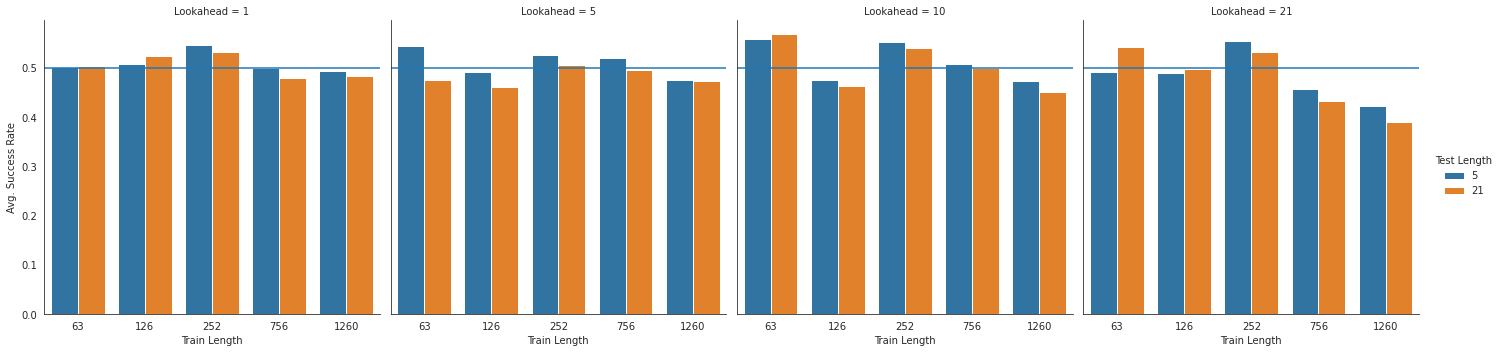

In [ ]:
plot = sns.catplot(x='Train Length',
            y='Avg. Success Rate',
            hue='Test Length',
            col='Lookahead',
            data=lr_metrics_long,
            kind='bar')

for ax_arr in plot.axes:
    for ax in ax_arr:
        ax.axhline(0.5)
plot

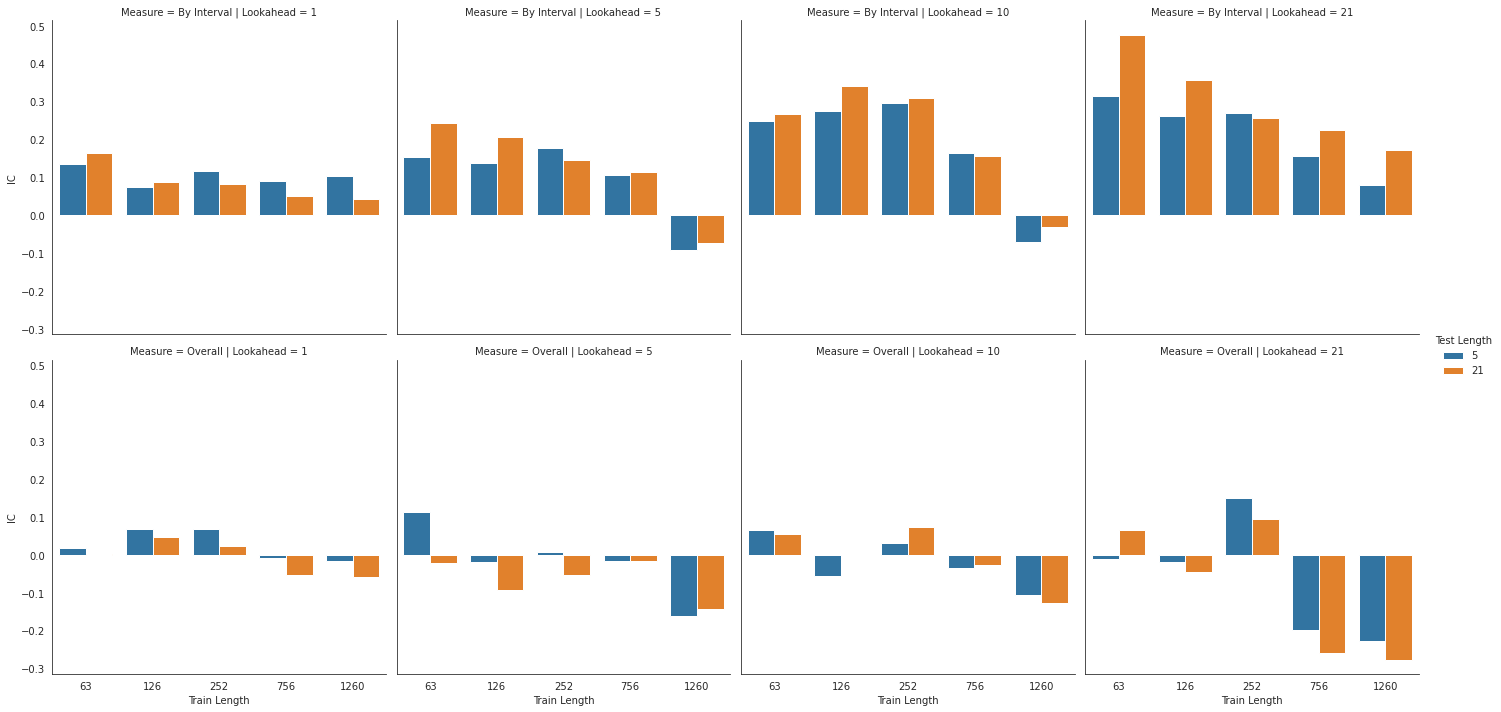

In [ ]:
sns.catplot(x='Train Length',
            y='IC',
            hue='Test Length',
            col='Lookahead',
            row='Measure',
            data=lr_metrics_long,
            kind='bar')

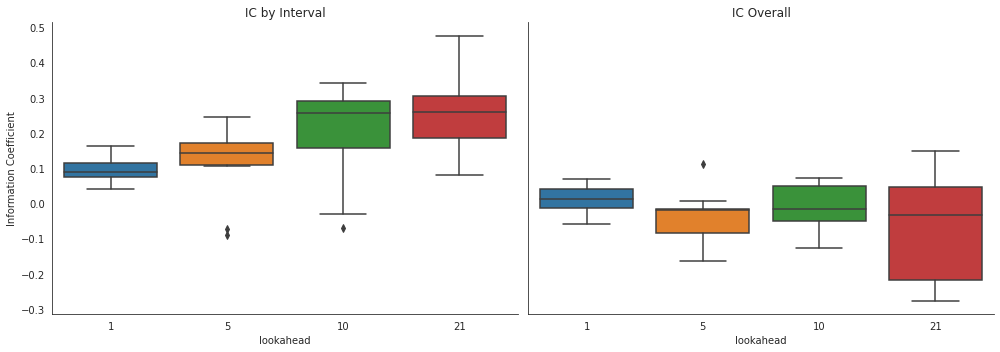

In [ ]:
fig, axes =plt.subplots(ncols=2, figsize=(14,5), sharey=True)
sns.boxplot(x='lookahead', y='ic_by_day',data=lr_metrics, ax=axes[0])
axes[0].set_title('IC by Interval')
sns.boxplot(x='lookahead', y='ic',data=lr_metrics, ax=axes[1])
axes[1].set_title('IC Overall')
axes[0].set_ylabel('Information Coefficient')
axes[1].set_ylabel('')
sns.despine()
fig.tight_layout()

In [ ]:
(lr_metrics.groupby('lookahead', group_keys=False)
 .apply(lambda x: x.nlargest(3, 'ic')))

,lookahead,train_length,test_length,ic_by_day,ic,avg_success
6,1,126,5,0.074000,0.069084,0.508000
4,1,252,5,0.117000,0.068493,0.546000
7,1,126,21,0.088745,0.046787,0.523810
18,5,63,5,0.153000,0.112725,0.544000
14,5,252,5,0.179000,0.006408,0.526000
13,5,756,21,0.113149,-0.015374,0.496032
25,10,252,21,0.308766,0.072674,0.539683
28,10,63,5,0.249000,0.064603,0.558000
29,10,63,21,0.266775,0.054532,0.567460
34,21,252,5,0.270000,0.149105,0.554000


In [ ]:
results_path = Path('results', 'return_predictions')
if not results_path.exists():
    results_path.mkdir(parents=True)
    
lr_metrics.to_csv(results_path / 'lin_reg_performance.csv', index=False)

In [ ]:
def get_fi(model):
    fi = model.feature_importance(importance_type='gain')
    return (pd.Series(fi / fi.sum(),
                      index=model.feature_name()))

In [ ]:
base_params = dict(
                    boosting_type='rf',
                   objective='regression',
                   bagging_freq=1)

In [ ]:
bagging_fraction_opts = [.5, .75, .95]
feature_fraction_opts = [.75, .95]
min_data_in_leaf_opts = [10, 25, 50]

In [ ]:
cv_params = list(product(bagging_fraction_opts,
                         feature_fraction_opts,
                         min_data_in_leaf_opts))
n_cv_params = len(cv_params)
n_cv_params

18

In [ ]:
sample_proportion = .5
sample_size = int(sample_proportion * n_cv_params)

cv_param_sample = np.random.choice(list(range(n_cv_params)), 
                                     size=int(sample_size), 
                                     replace=False)
cv_params_ = [cv_params[i] for i in cv_param_sample]
print('# CV parameters:', len(cv_params_))

# CV parameters: 9


In [ ]:
num_iterations = [25] + list(range(50, 501, 25))
num_boost_round = num_iterations[-1]

train_lengths = [5 * YEAR, 3 * YEAR, YEAR, 126, 63]
test_lengths = [5, 21]

test_params = list(product(train_lengths, test_lengths))
n_test_params = len(test_params)

sample_proportion = 1.0
sample_size = int(sample_proportion * n_test_params)

test_param_sample = np.random.choice(list(range(n_test_params)), 
                                     size=int(sample_size), 
                                     replace=False)
test_params_ = [test_params[i] for i in test_param_sample]
print('Train configs:', len(test_params_))
print('CV Iterations:', len(cv_params_) * len(test_params_))

Train configs: 10
CV Iterations: 90


In [ ]:
rf_clf = RandomForestClassifier(oob_score=True, 
                                n_jobs=-1,
                                random_state=42, 
                                verbose=1)

cv = MultipleTimeSeriesCV(n_splits=36,
                          test_period_length=21,
                          lookahead=5,
                          train_period_length=2 * 252)

cv_score = cross_val_score(estimator=rf_clf,
                           X=pd.get_dummies(data.drop('fwd_ret_01', axis=1)),
                           y=(data['fwd_ret_01'] > 0).astype(int),
                           scoring='roc_auc',
                           cv=cv,
                           n_jobs=-1,
                           verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   12.5s finished


array([       nan,        nan,        nan, 0.47727273, 0.62727273,
       0.53636364, 0.54090909, 0.65865385, 0.63125   , 0.60648148,
       0.62727273, 0.65277778, 0.65740741, 0.76818182, 0.49074074,
       0.74545455, 0.56632653, 0.62019231, 0.46323529, 0.61574074,
       0.55555556, 0.70408163, 0.70454545, 0.78703704, 0.67346939,
       0.85185185, 0.60185185, 0.61574074, 0.38425926, 0.48557692,
       0.73181818, 0.66346154, 0.51923077, 0.75462963, 0.60185185,
       0.66826923])

In [ ]:
np.mean(cv_score[~np.isnan(cv_score)])

0.6239019483496819

In [ ]:
categoricals = ['year', 'weekday', 'month']
for feature in categoricals:
    data[feature] = pd.factorize(data[feature], sort=True)[0]

labels = sorted(cv_data.filter(like='fwd').columns)
features = cv_data.columns.difference(labels).tolist()

lookahead, train_length, test_length = 1, 252, 5

label_dict = dict(zip(lookaheads, labels))


In [ ]:


cv_store = Path(results_path / 'parameter_tuning.h5')

ic_cols = ['bagging_fraction',
           'feature_fraction',
           'min_data_in_leaf',
           't'] + [str(n) for n in num_iterations]

def format_time(t):
    """Return a formatted time string 'HH:MM:SS
    based on a numeric time() value"""
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return f'{h:0>2.0f}:{m:0>2.0f}:{s:0>2.0f}'

for lookahead in lookaheads:
    for train_length, test_length in test_params_:
        n_splits = int(2 * YEAR / test_length)
        print(f'Lookahead: {lookahead:2.0f} | Train: {train_length:3.0f} | '
              f'Test: {test_length:2.0f} | Params: {len(cv_params_):3.0f}')

        cv = MultipleTimeSeriesCV(n_splits=n_splits,
                                  test_period_length=test_length,
                                  train_period_length=train_length,
                                  lookahead=lookahead)

        label = label_dict[lookahead]
        outcome_data = data.loc[:, features + [label]].dropna()

        lgb_data = lgb.Dataset(data=outcome_data.drop(label, axis=1),
                               label=outcome_data[label],
                               categorical_feature=categoricals,
                               free_raw_data=False)
        predictions, daily_ic, ic, feature_importance = [], [], [], []
        key = f'{lookahead}/{train_length}/{test_length}'
        T = 0
        for p, (bagging_fraction, feature_fraction, min_data_in_leaf) in enumerate(cv_params_):
            params = base_params.copy()
            params.update(dict(bagging_fraction=bagging_fraction,
                               feature_fraction=feature_fraction,
                               min_data_in_leaf=min_data_in_leaf))

            start = time()
            cv_preds, nrounds = [], []
            for i, (train_idx, test_idx) in enumerate(cv.split(X=outcome_data)):
                lgb_train = lgb_data.subset(train_idx.tolist()).construct()
                lgb_test = lgb_data.subset(test_idx.tolist()).construct()

                model = lgb.train(params=params,
                                  train_set=lgb_train,
                                  num_boost_round=num_boost_round,
                                  verbose_eval=False)
                if i == 0:
                    fi = get_fi(model).to_frame()
                else:
                    fi[i] = get_fi(model)

                test_set = outcome_data.iloc[test_idx, :]
                X_test = test_set.loc[:, model.feature_name()]
                y_test = test_set.loc[:, label]
                y_pred = {str(n): model.predict(X_test, num_iteration=n)
                          for n in num_iterations}
                cv_preds.append(y_test.to_frame(
                    'y_test').assign(**y_pred).assign(i=i))
                nrounds.append(model.best_iteration)
            feature_importance.append(fi.T.describe().T.assign(bagging_fraction=bagging_fraction,
                                                               feature_fraction=feature_fraction,
                                                               min_data_in_leaf=min_data_in_leaf))
            cv_preds = pd.concat(cv_preds).assign(bagging_fraction=bagging_fraction,
                                                  feature_fraction=feature_fraction,
                                                  min_data_in_leaf=min_data_in_leaf)

            predictions.append(cv_preds)

            success.append(np.sum(y_test * y_pred > 0) / y_test.size)

            cv_ic = [spearmanr(cv_preds['y_test'], cv_preds[str(n)])[0]
                  for n in num_iterations]

            T += time() - start
            ic.append([bagging_fraction, feature_fraction,
                       min_data_in_leaf, lookahead] + cv_ic)

            msg = f'{p:3.0f} | {format_time(T)} | '
            msg += f'{bagging_fraction:3.0%} | {feature_fraction:3.0%} | {min_data_in_leaf:5,.0f} | '
            msg += f'{max(cv_ic):6.2%} | {np.mean(cv_ic):6.2%} | {min(cv_ic):6.2%}'
            print(msg)

        m = pd.DataFrame(ic, columns=ic_cols)
        m.to_hdf(cv_store, 'ic/' + key)
        pd.concat(feature_importance).to_hdf(cv_store, 'fi/' + key)
        pd.concat(predictions).to_hdf(cv_store, 'predictions/' + key)

Lookahead:  1 | Train: 756 | Test:  5 | Params:   9
  0 | 00:01:35 | 75% | 75% |    10 |  2.65% | -0.28% | -0.89%
  1 | 00:02:28 | 75% | 95% |    50 |  0.13% | -0.65% | -1.38%
  2 | 00:03:10 | 50% | 75% |    50 | -0.58% | -1.08% | -2.14%
  3 | 00:04:48 | 50% | 75% |    10 |  0.59% | -0.56% | -2.67%
  4 | 00:05:45 | 95% | 75% |    50 |  1.22% |  0.74% |  0.28%
  5 | 00:07:05 | 95% | 75% |    25 | -2.77% | -4.64% | -5.37%
  6 | 00:07:50 | 50% | 95% |    50 | -1.69% | -2.36% | -3.93%
  7 | 00:09:18 | 95% | 95% |    25 | -4.38% | -6.28% | -6.88%
  8 | 00:10:16 | 50% | 75% |    25 |  0.73% | -0.83% | -2.01%
Lookahead:  1 | Train:  63 | Test: 21 | Params:   9
  0 | 00:00:08 | 75% | 75% |    10 | -4.66% | -4.95% | -5.35%
  1 | 00:00:11 | 75% | 95% |    50 |   nan% |   nan% |   nan%
  2 | 00:00:14 | 50% | 75% |    50 |   nan% |   nan% |   nan%
  3 | 00:00:20 | 50% | 75% |    10 | -1.16% | -1.47% | -2.21%
  4 | 00:00:22 | 95% | 75% |    50 |   nan% |   nan% |   nan%
  5 | 00:00:27 | 95% | 75% |

In [ ]:
id_vars = ['train_length',
           'test_length',
           'bagging_fraction',
           'feature_fraction',
           'min_data_in_leaf',
           't', 'date']

daily_ic, ic = [], []
for t in lookaheads:
    print(t)
    with pd.HDFStore(cv_store) as store:
        keys = [k[1:] for k in store.keys() if k.startswith(f'/fi/{t}')]
        for key in keys:
            train_length, test_length = key.split('/')[2:]
            print(train_length, test_length)
            k = f'{t}/{train_length}/{test_length}'
            cols = {'t': t,
                    'train_length': int(train_length),
                    'test_length': int(test_length)}

            ic.append(pd.melt(store['ic/' + k]
                              .assign(**cols),
                              id_vars=id_vars[:-1],
                              value_name='ic',
                              var_name='rounds')
                      .apply(pd.to_numeric))
                   
ic = pd.concat(ic, ignore_index=True)

1
756 21
756 5
63 21
63 5
252 21
252 5
1260 21
1260 5
126 21
126 5
756 21
756 5
63 21
63 5
252 21
252 5
1260 21
1260 5
126 21
126 5
5
756 21
756 5
63 21
63 5
252 21
252 5
1260 21
1260 5
126 21
126 5
10
756 21
756 5
63 21
63 5
252 21
252 5
1260 21
1260 5
126 21
126 5
21
756 21
756 5
63 21
63 5
252 21
252 5
1260 21
1260 5
126 21
126 5


In [ ]:
ic.groupby('t').apply(lambda x: x.nlargest(3, 'ic'))

train_length  test_length  bagging_fraction  feature_fraction  min_data_in_leaf   t  rounds        ic
t                                                                                                             
1  902            252            5              0.50              0.75                50   1      25  0.089472
   2702           252            5              0.50              0.75                50   1      25  0.089472
   906            252            5              0.50              0.95                50   1      25  0.082165
5  4154            63            5              0.95              0.75                25   5      50  0.131240
   4145            63            5              0.95              0.75                25   5      25  0.130214
   4208            63            5              0.95              0.75                25   5     200  0.128286
10 6147           252           21              0.75              0.75                10  10     100  0.185928
   6156           252           21              0.75              0.75                10  10     125  0.185055
   6165           252           21              0.75              0.75                10  10     150  0.182684
21 8100           252            5              0.75              0.75                10  21      25  0.254814
   8109           252            5              0.75              0.75                10  21      50  0.248583
   8118           252            5              0.75              0.75                10  21      75  0.248455

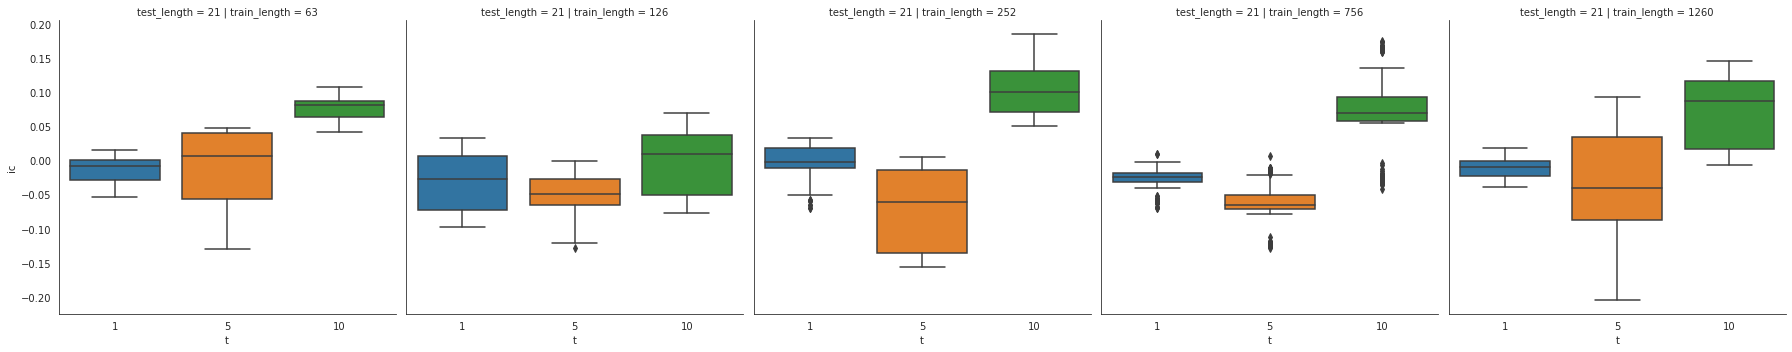

In [ ]:
g = sns.catplot(x='t',
                y='ic',
                col='train_length',
                row='test_length',
                data=ic[(ic.test_length == 21) & (ic.t < 21)],
                kind='box')

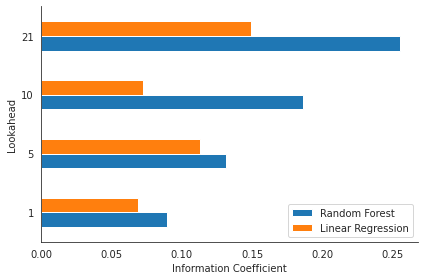

In [ ]:
with sns.axes_style("white"):
    ax = (ic.groupby('t').ic.max().to_frame('Random Forest')
     .join(lr_metrics.groupby('lookahead').ic.max().to_frame('Linear Regression')).plot.barh())
    ax.set_ylabel('Lookahead')
    ax.set_xlabel('Information Coefficient')
    sns.despine()
    plt.tight_layout();